## CGAN(Conditional GAN)
GAN可以用来生成接近真实的图片,但普通的GAN太过自由而不可控了,而CGAN(Conditional GAN)是一种带条件约束的GAN，在生成模型(D)和判别模型(G)的建模中均引入条件变量.这些条件变量可以基于多种信息，例如类别标签，用于图像修复的部分数据等等.在这个接下来这个CGAN中我们引入类别标签作为G和D的条件变量.

下面的CGAN网络结构与之前的模型最大的不同是在G和D的输入中加入了类别标签labels,在G中,labels(用one-hot向量表示,如有3个类(0/1/2),第2类的one-hot向量为\[0, 0, 1\])和原来的噪声z一起输入到第一层中,在D中,labels和输入图片一起输入到卷积层中,labels中每个label的shape为(nclasses,imsize,imsize)的张量表示,其正确类别的channel全为1,其余channel全为0。

In [9]:
import os
import json
import torch
import random
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from utils import show
from PIL import Image
from torch.utils.data import Dataset
from utils import initialize_weights
%matplotlib inline

In [10]:
class Generator(nn.Module):
    def __init__(self, nz, nc, ngf, imsize, nclasses):
        """nz(int): 输入噪声的维度
            nc(int): 输入图像的通道数
            ngf(int): Generator模型的宽度以控制模型的capacity """
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz + nclasses, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
        )
        if imsize == 64:
            self.convout = nn.Sequential(
                nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
                nn.Tanh()
            )
            # state size. (nc) x 64 x 64
        elif imsize == 32:
            self.convout = nn.Sequential(
                nn.Conv2d( ngf, nc, 3, 1, 1, bias=False),
                nn.Tanh()
            )
            # state size. (nc) x 32 x 32
        else:
            raise NotImplementedError()
        initialize_weights(self)
    def forward(self, x, labels):
        x = torch.cat((x, labels), dim=1) # （batchsize, nz + nclasses)
        x = x.unsqueeze(-1).unsqueeze(-1) # （batchsize, nz + nclasses, 1, 1)
        x = self.main(x)
        x = self.convout(x)
        return x
class Discriminator(nn.Module):
    def __init__(self, nc, ndf, imsize, nclasses):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x imsize x imsize
            nn.Conv2d(nc + nclasses, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x (imsize/2) x (imsize/2)
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x (imsize/4) x (imsize/4)
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x (imsize/8) x (imsize/8)
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x (imsize/16) x (imsize/16)
            nn.Conv2d(ndf * 8, 1, imsize//16, 1, 0, bias=False),
            nn.Sigmoid()
            # state size. 1 x 1 x 1
        )
        initialize_weights(self)
    def forward(self, x, labels):
        img_size = x.shape[2]
        labels = labels.unsqueeze(-1).unsqueeze(-1).repeat(1, 1, img_size, img_size)
        x = torch.cat((x, labels), dim=1)
        x = self.main(x)
        return x        

In [19]:
def train(trainloader, G, D, G_optimizer, D_optimizer, loss_func, device, z_dim, nclasses):
    # set train mode
    D.train()
    G.train()
    D_total_loss = 0
    G_total_loss = 0
    for i, (x, y) in enumerate(trainloader):
        x = x.to(device)
        batch_size_ = x.size(0)
        image_size = x.size(2)
        # real label and fake label
        real_label = torch.ones(batch_size_, 1).to(device)
        fake_label = torch.zeros(batch_size_, 1).to(device)
        
        if len(y.shape) == 1:
            # 如果y是整数型的label则需要转化为condition vectors
            y = vecs[y]
        y = y.to(device)
        z = torch.randn(batch_size_, z_dim).to(device)
        # update D network
        # D optimizer zero grads
        D_optimizer.zero_grad()
        # D real loss from real images
        d_real = D(x, y)
        d_real_loss = loss_func(d_real, real_label)
        # D fake loss from fake images generated by G
        g_z = G(z, y)
        d_fake = D(g_z, y)
        d_fake_loss = loss_func(d_fake, fake_label)
        # D backward and step
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        D_optimizer.step()
        # update G network
        # G optimizer zero grads
        G_optimizer.zero_grad()
        # G loss
        g_z = G(z, y)
        d_fake = D(g_z, y)
        g_loss = loss_func(d_fake, real_label)
        # G backward and step
        g_loss.backward()
        G_optimizer.step()
        D_total_loss += d_loss.item()
        G_total_loss += g_loss.item()
    return D_total_loss / len(trainloader), G_total_loss / len(trainloader)
def run_gan(trainloader, G, D, G_optimizer, D_optimizer, loss_func, n_epochs, device, nz, nclasses):
    d_loss_hist = []
    g_loss_hist = []
    for epoch in range(n_epochs):
        d_loss, g_loss = train(trainloader, G, D, G_optimizer, D_optimizer, loss_func, device, 
                               nz, nclasses)
        print('Epoch {}: Train D loss: {:.4f}, G loss: {:.4f}'.format(epoch, d_loss, g_loss))
        d_loss_hist.append(d_loss)
        g_loss_hist.append(g_loss)
        if epoch == 0 or (epoch + 1) % 10 == 0:
            visualize_results(G, device, nz, nclasses)
    return d_loss_hist, g_loss_hist

### CGAN：多标签人脸生成
[CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html)是一个多标签的人脸数据集，每张人脸图像提供了多达40种属性的标注，对于我们使用CGAN生成自己想要的人脸来说是一个很好的数据集。

在40种属性中，我们筛选出了其中11种比较明显的特征，把具有这11种特征的人脸图像选取了三万张作为本次实验的数据集。label的格式为11维的向量，某一维度为1则说明该人脸具有这一维对应的特征。下面我们读取这个数据集，显示前10张图像和它们对应的属性。

In [21]:
class CelebDataset(Dataset):
    def __init__(self, root, transform):
        super(CelebDataset, self).__init__()
        self.transform = transform if transform is not None else lambda x: x
        self.root = root
        self.imgs = []
        with open(os.path.join(root, 'label.json'), mode='r') as f:
            self.label_dict = json.load(f)
        for f in os.listdir(os.path.join(root, 'imgs')):
            self.imgs.append(f)
    def __getitem__(self, index):
        name = self.imgs[index]
        img = Image.open(os.path.join(self.root, 'imgs', name))
        label = torch.Tensor(self.label_dict[name])
        img = self.transform(img)
        return img, label
    def __len__(self):
        return len(self.imgs)
def load_celeb_data():
    transform = transforms.Compose([
        transforms.Resize(64),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    ds = CelebDataset('./data/celeb', transform)
    return ds
dataset = load_celeb_data()

Epoch 0: Train D loss: 0.7321, G loss: 3.9455


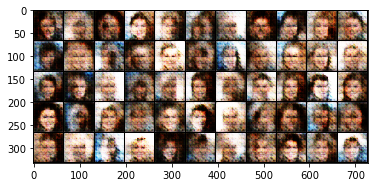

Epoch 1: Train D loss: 0.8452, G loss: 3.4565
Epoch 2: Train D loss: 0.8164, G loss: 3.1678
Epoch 3: Train D loss: 0.7757, G loss: 2.9970
Epoch 4: Train D loss: 0.6764, G loss: 2.9623
Epoch 5: Train D loss: 0.6783, G loss: 2.8173
Epoch 6: Train D loss: 0.7403, G loss: 2.7017
Epoch 7: Train D loss: 0.7595, G loss: 2.5378
Epoch 8: Train D loss: 0.8015, G loss: 2.4710
Epoch 9: Train D loss: 0.7963, G loss: 2.4370


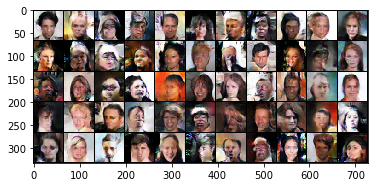

Epoch 10: Train D loss: 0.7929, G loss: 2.4446
Epoch 11: Train D loss: 0.7960, G loss: 2.4691
Epoch 12: Train D loss: 0.7597, G loss: 2.4653
Epoch 13: Train D loss: 0.7682, G loss: 2.5311
Epoch 14: Train D loss: 0.7277, G loss: 2.5855
Epoch 15: Train D loss: 0.6968, G loss: 2.6750
Epoch 16: Train D loss: 0.6673, G loss: 2.7825
Epoch 17: Train D loss: 0.5972, G loss: 2.9618
Epoch 18: Train D loss: 0.5222, G loss: 3.1784
Epoch 19: Train D loss: 0.5633, G loss: 3.4059


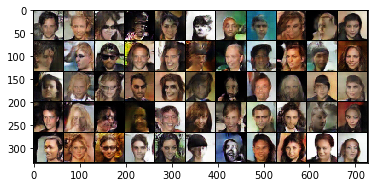

Epoch 20: Train D loss: 0.3745, G loss: 3.4693
Epoch 21: Train D loss: 0.4176, G loss: 3.7161
Epoch 22: Train D loss: 0.4230, G loss: 3.8889
Epoch 23: Train D loss: 0.3230, G loss: 4.2180
Epoch 24: Train D loss: 0.2978, G loss: 4.1072
Epoch 25: Train D loss: 0.2550, G loss: 4.4085
Epoch 26: Train D loss: 0.3022, G loss: 4.5934
Epoch 27: Train D loss: 0.2538, G loss: 4.3838
Epoch 28: Train D loss: 0.2513, G loss: 4.4940
Epoch 29: Train D loss: 0.2423, G loss: 4.6601


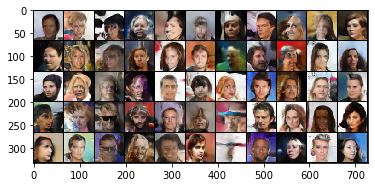

Epoch 30: Train D loss: 0.3505, G loss: 4.5991
Epoch 31: Train D loss: 0.1629, G loss: 4.6169
Epoch 32: Train D loss: 0.2401, G loss: 4.8800
Epoch 33: Train D loss: 0.2338, G loss: 4.8044
Epoch 34: Train D loss: 0.1754, G loss: 4.9716
Epoch 35: Train D loss: 0.1423, G loss: 5.0906
Epoch 36: Train D loss: 0.2773, G loss: 4.9956
Epoch 37: Train D loss: 0.2563, G loss: 4.9054
Epoch 38: Train D loss: 0.1818, G loss: 4.9901
Epoch 39: Train D loss: 0.2530, G loss: 5.1875


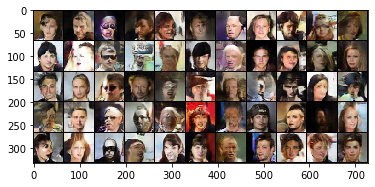

Epoch 40: Train D loss: 0.1553, G loss: 5.2085
Epoch 41: Train D loss: 0.2029, G loss: 5.2906
Epoch 42: Train D loss: 0.1499, G loss: 5.1558
Epoch 43: Train D loss: 0.1970, G loss: 5.5714
Epoch 44: Train D loss: 0.1991, G loss: 5.3522
Epoch 45: Train D loss: 0.1692, G loss: 5.2567
Epoch 46: Train D loss: 0.1897, G loss: 5.3849
Epoch 47: Train D loss: 0.1657, G loss: 5.4776
Epoch 48: Train D loss: 0.1279, G loss: 5.4857
Epoch 49: Train D loss: 0.1642, G loss: 5.5009


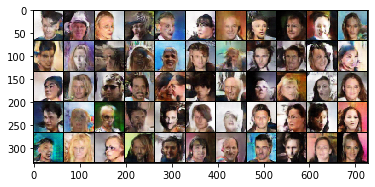

Epoch 50: Train D loss: 0.1903, G loss: 5.6431
Epoch 51: Train D loss: 0.1206, G loss: 5.6213
Epoch 52: Train D loss: 0.1848, G loss: 5.6354
Epoch 53: Train D loss: 0.2466, G loss: 5.4749
Epoch 54: Train D loss: 0.0495, G loss: 5.6933
Epoch 55: Train D loss: 0.2174, G loss: 5.5722
Epoch 56: Train D loss: 0.1433, G loss: 5.5896
Epoch 57: Train D loss: 0.2324, G loss: 5.5454
Epoch 58: Train D loss: 0.1808, G loss: 5.6648
Epoch 59: Train D loss: 0.1359, G loss: 5.7114


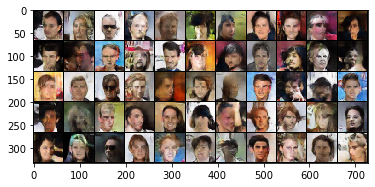

In [22]:
nclasses = 11
# condition vectors
vecs = torch.eye(nclasses)
# z dim
nz = 100
learning_rate = 0.0002
betas = (0.5, 0.999)
# image size and channel
imsize=64
nc=3
# model capacity
ngf = 64
ndf = 64
n_epochs = 60
batch_size = 64
device = torch.device('cuda:0')
train_dataset = load_celeb_data()
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, drop_last=True, shuffle=True)
bceloss = nn.BCELoss().to(device)
G = Generator(nz, nc, ngf, imsize, nclasses)
D = Discriminator(nc, ndf, imsize, nclasses)
G.to(device)
D.to(device)
G_optimizer = optim.Adam(G.parameters(), lr=learning_rate, betas=betas)
D_optimizer = optim.Adam(D.parameters(), lr=learning_rate, betas=betas)
d_loss_hist, g_loss_hist = run_gan(trainloader, G, D, G_optimizer, D_optimizer, bceloss, 
                                   n_epochs, device, nz, nclasses)
torch.save(G.state_dict(), 'celeb_generator.pth')

Wavy_Hair Eyeglasses 

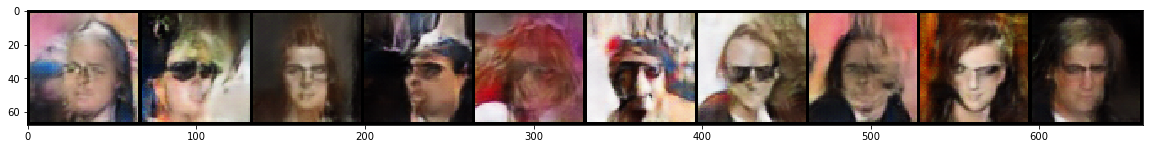

Male Female Mustache 

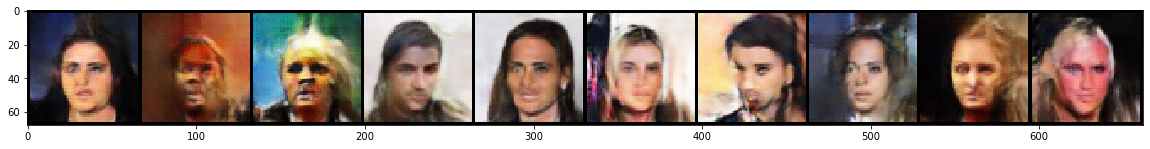

Straight_Hair Bangs Male Smiling 

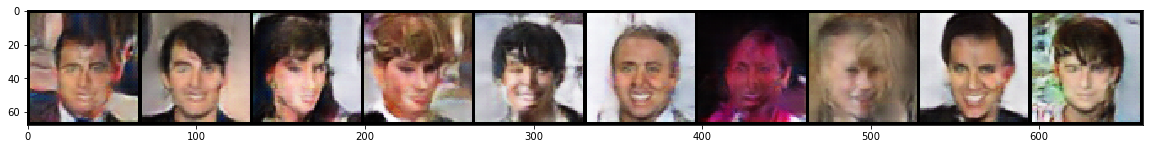

In [62]:
#利用训练好的模型，生成具有指定两种，三种，四种特性的图片各十张
nz = 100
nc=3
ngf = 64
imsize=64
nclasses = 11
learning_rate = 0.0002
betas = (0.5, 0.999)
attributes = ['Black_Hair', 'Blond_Hair', 'Eyeglasses', 'Mustache', 
              'Smiling', 'Bangs', 'Bald', 'Male', 'Wavy_Hair', 
              'Straight_Hair', 'Female']
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)
def visualize_results2(G, device, z_dim, nclasses):
    nrows=10
    z = torch.randn(1 * 10, z_dim).to(device)
    y = torch.zeros(10,11).to(device)
    for i in random.sample(range(11),nclasses):
        print(attributes[i], end=' ')
        for j in range(10):
            y[j][i]=1
    g_z = G(z, y)
    show(torchvision.utils.make_grid(denorm(g_z.detach().cpu()), nrow=10), figsize=20)
model = Generator(nz, nc, ngf, imsize, nclasses).to(device)
model.load_state_dict(torch.load('celeb_generator.pth'))
model.eval()
device = torch.device('cuda:0')
visualize_results2(model,device,nz,2)
visualize_results2(model,device,nz,3)
visualize_results2(model,device,nz,4)